# Evaluación del gemelo digital

En este cuaderno se lleva a cabo la evaluación del gemelo digital del proceso de descarga de sales. Para evaluar este gemelo digital se dispone de datos de prácticamente 2 años, desde el 6 de enero de 2017 hasta el 31 de diciembre de 2018. La evaluación consistirá en la simulación de cómo se hubiera comportado el gemelo a lo largo de todo este tiempo. Se generará un nuevo modelo cada mes, entrenándolo con los datos de los tres meses anteriores. El gemelo digital por tanto, renovará su modelo cada mes. El modelo a emplear será el que mejor resultado ha dado en la sección anterior, en la que se probarón varios modelos distintos sobre todo el dataset. El mejor modelo resulto ser uno de tipo Random Forest Regressor.

## Carga de datos

Importación de librerias

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

Se cargan los datos procesados previamente desde el fichero pickle en un dataframe y se determina su tamaño

In [3]:
datos = pd.read_pickle('Datos_descarga_proc_2023-05-05_134703_conPCA.pickle')
datos.shape

(116185, 8)

In [4]:
datos.head()

,componente1,componente2,componente3,componente4,componente5,componente6,componente7,eficiencia_descarga
time,,,,,,,,
2017-01-16 17:53:00,-0.347299,-0.217648,-0.162539,0.477760,0.311185,0.013841,0.112844,0.306006
2017-01-16 17:54:00,-0.350084,-0.227951,-0.177204,0.474238,0.361250,0.014090,0.155471,0.307990
2017-01-16 17:55:00,-0.353388,-0.218600,-0.147487,0.493382,0.293289,0.024799,0.094036,0.312124
2017-01-16 17:56:00,-0.353650,-0.215037,-0.148358,0.482319,0.328331,0.025416,0.134572,0.314885
2017-01-16 17:57:00,-0.356481,-0.217904,-0.159874,0.470682,0.384702,0.019514,0.191868,0.317008


In [5]:
datos.tail()

,componente1,componente2,componente3,componente4,componente5,componente6,componente7,eficiencia_descarga
time,,,,,,,,
2018-11-01 19:12:00,-0.492497,-0.477170,-0.144359,0.109519,-0.046130,-0.196525,0.149488,0.355668
2018-11-01 19:13:00,-0.495538,-0.473664,-0.147010,0.116767,-0.031583,-0.211864,0.148064,0.354810
2018-11-01 19:14:00,-0.494464,-0.467435,-0.128952,0.113411,-0.084652,-0.204511,0.112542,0.354186
2018-11-01 19:15:00,-0.495465,-0.464610,-0.127459,0.118599,-0.075286,-0.201137,0.096678,0.354841
2018-11-01 19:16:00,-0.495829,-0.474462,-0.130233,0.114132,-0.031570,-0.149067,0.076306,0.354674


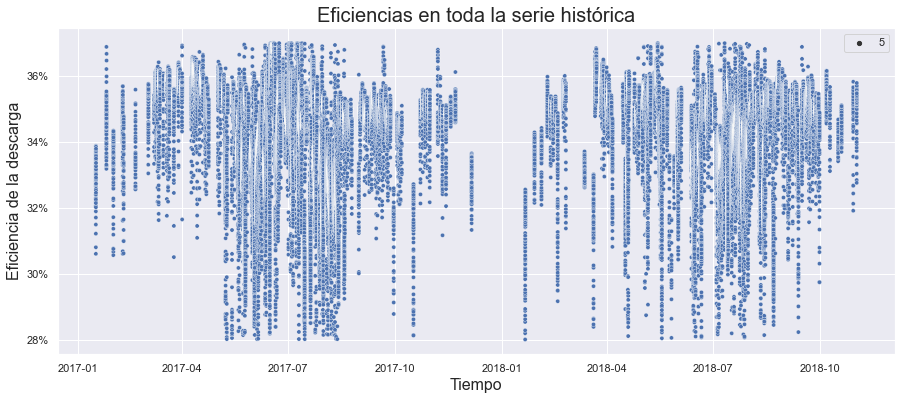

In [15]:
sns.set(style="darkgrid")
plt.figure(figsize=(15, 6))
ax = sns.scatterplot(data=datos, x=datos.index, y="eficiencia_descarga", size=5)

plt.xlabel("Tiempo", fontsize=16)
plt.ylabel("Eficiencia de la descarga", fontsize=16)
plt.title("Eficiencias en toda la serie histórica", fontsize=20)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.show()

## Entrenamiento modelos

Debido a que se va a entrenar varios modelos, se crea una función que realice este entrenamiento y a la que se pueda llamar posteriormente

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

def entrenamientoModelo (datos):
        # Función para entrenar los modelos RandomForestRegressor a partir de un dataframe de datos
        X = datos.drop('eficiencia_descarga', axis=1)
        y = datos['eficiencia_descarga']
        
        RF_regressor = RandomForestRegressor()

        param = {'bootstrap': [True, False],
            'max_depth': [10, 30, 50, 70, 90, None],
            'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [2, 4],
            'min_samples_split': [2, 5, 10],
            'n_estimators': [400, 800, 1200, 1600, 2000]}

        grid = RandomizedSearchCV(estimator= RF_regressor, param_distributions= param, n_iter= 100, cv= 5, random_state= 1, n_jobs= -1)

        grid_fit = grid.fit(X = X, y = y)
        return grid_fit.best_estimator_ # Devuelvo el mejor modelo encontrado

Los modelos se van a entrenar con los datos de los 3 meses anteriores. Como el primer mes del dataset es enero de 2017, el primer modelo se entrenará con datos de enero, febrero y marzo y podrá ser utilizado para predecir la eficiencia de descarga durante el mes de abril de 2017. El último modelo se entrenará con los datos de julio, agosto y septiembre de 2018 y podrá ser utilizado para predecir la eficiencia de descarga durante el mes de octubre de 2018 (En noviembre de 2018 solo hay datos 1 día, con pocos valores para hacer una evaluación relevante).

In [8]:
from sklearn.metrics import mean_squared_error, r2_score
import datetime
import locale
locale.setlocale(locale.LC_TIME, 'es_ES') # Se establece la localización para obtener los nombres de los meses en español

fecha_inicial = '2017-01-01' 
fecha_final = '2018-10-31'
inicio = pd.to_datetime(fecha_inicial)
meses_entrenamiento = 3
mes_evaluacion = 4  # El primer modelo se evalua en abril de 2017, el mes 4
año_evaluacion = 2017
modelos = [] # lista de modelos
while inicio < pd.to_datetime(fecha_final) - pd.DateOffset(months=meses_entrenamiento):

    # Entrenamiento del modelo
    fin = inicio + pd.DateOffset(months=meses_entrenamiento)
    datos_trimestrales = datos.loc[inicio:fin]  # Subconjunto de datos para entrenar al modelo
    modelo = entrenamientoModelo(datos_trimestrales)    # Entrenamiento del modelo
    modelos.append(modelo)  # Se añade el modelo a la lista de modelos
    fecha_final_entrenamiento = fin - pd.DateOffset(days=1)
    nombre_meses_entrenamiento = inicio.strftime('%B') + ' - ' + fecha_final_entrenamiento.strftime('%B')
    print('Modelo entrenado con los datos de los meses: ', nombre_meses_entrenamiento)
    inicio = inicio + pd.DateOffset(months=1)

    # Evaluación del modelo en el mes siguiente
    datos_evaluacion = datos.loc[(datos.index.month == mes_evaluacion) & (datos.index.year == año_evaluacion)]
    X_eval = datos_evaluacion.drop('eficiencia_descarga', axis=1)
    y_eval = datos_evaluacion['eficiencia_descarga']
    predicciones = modelo.predict(X_eval)
    mse = mean_squared_error(y_eval, predicciones)
    rmse_rf = np.sqrt(mse)
    r2_rf = r2_score(y_eval, predicciones)
    datetime_evaluacion = datetime.datetime(año_evaluacion, mes_evaluacion, 1)
    nombre_mes_evaluacion = datetime_evaluacion.strftime('%B %Y')
    print('Métricas del modelo aplicado a ', nombre_mes_evaluacion)
    print("RMSE: {:2f}%".format(rmse_rf*100))
    print("R2: ", r2_rf)
    print("*************************************************")
    if mes_evaluacion == 12:
        mes_evaluacion = 1
        año_evaluacion += 1
    else:      
        mes_evaluacion += 1

Modelo entrenado con los datos de los meses:  enero - marzo
Métricas del modelo aplicado a  abril 2017
RMSE: 0.795556%
R2:  -0.8775927116837436
*************************************************
Modelo entrenado con los datos de los meses:  febrero - abril
Métricas del modelo aplicado a  mayo 2017
RMSE: 1.555094%
R2:  -0.024696935505681417
*************************************************
Modelo entrenado con los datos de los meses:  marzo - mayo
Métricas del modelo aplicado a  junio 2017
RMSE: 1.274023%
R2:  0.25294086159923124
*************************************************
Modelo entrenado con los datos de los meses:  abril - junio
Métricas del modelo aplicado a  julio 2017
RMSE: 1.592241%
R2:  0.2535191141443097
*************************************************
Modelo entrenado con los datos de los meses:  mayo - julio
Métricas del modelo aplicado a  agosto 2017
RMSE: 1.013732%
R2:  0.39228259624751316
*************************************************
Modelo entrenado con los dato

Se guarda la lista de los modelos entrenados en un archivo para no tener que volver a entrenarlos si se pierde la sesión.

In [10]:
import pickle

# Guardar la lista de modelos en un archivo
with open('modelos_3meses.pickle', 'wb') as f:
    pickle.dump(modelos, f)

## Evaluación de los modelos

In [20]:
import pickle

# Cargar la lista de modelos desde el archivo
with open('modelos_3meses.pickle', 'rb') as f:
    modelos = pickle.load(f)

C:\Users\luis.millan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.1.3 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\luis.millan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.1.3 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Las métricas obtenidas para estos modelos de 3 meses son en general peores que las obtenidas con el modelo entrenado con todos los datos. Para ver como afecta el número de registros a las métricas, se gráfican los RMSE obtenidos en cada modelo junto con el número de registros usados para entrenarlo.

In [24]:
from sklearn.metrics import mean_squared_error, r2_score

fecha_inicial = '2017-01-01' 
fecha_final = '2018-10-31'
inicio = pd.to_datetime(fecha_inicial)
meses_entrenamiento = 3
rmse_modelos = [] # Lista que contendrá los rmse de cada modelo
registros_entrenamiento = [] # Lista que contendrá el nº de registros usados en el entrenamiento de cada modelo

for i, modelo in enumerate(modelos):
    # Se determina el rango de fechas correspondiente al entrenamiento y a la validacion
    inicio_entrenamiento = inicio + pd.DateOffset(months=i)
    fin_entrenamiento = inicio_entrenamiento + pd.DateOffset(months=meses_entrenamiento) - pd.DateOffset(days=1)
    inicio_validacion = fin_entrenamiento + pd.DateOffset(days=1)
    fin_validacion = inicio_validacion + pd.DateOffset(months=1) - pd.DateOffset(days=1)

    # Se obtienen los datos correspondientes al entrenamiento y a la validacion
    datos_entrenamiento = datos.loc[inicio_entrenamiento:fin_entrenamiento]
    datos_validacion = datos.loc[inicio_validacion:fin_validacion]
    
    # Se obtienen las predicciones de los datos de validacion
    X = datos_validacion.drop(["eficiencia_descarga"], axis=1) # Entradas del modelo
    predicciones = modelo.predict(X)
    eficiencias_reales = datos_validacion["eficiencia_descarga"]

    # Métricas de evaluación
    mse = mean_squared_error(eficiencias_reales, predicciones)
    rmse = np.sqrt(mse)
    rmse_modelos.append(rmse)

    # Número de registros usados en el entrenamiento
    registros_entrenamiento.append(datos_entrenamiento.shape[0])

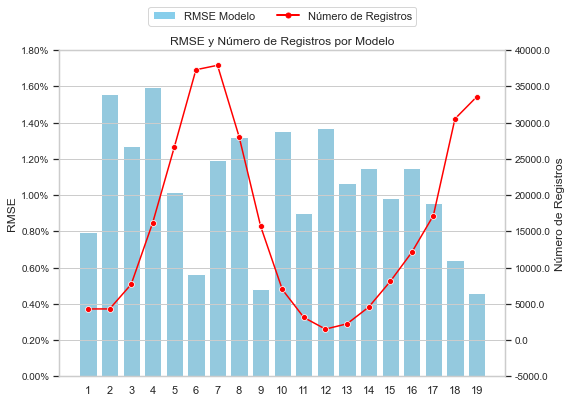

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Crear una lista de modelos
etiquetas_modelos = [i+1 for i in range(len(rmse_modelos))]

# Configurar el estilo y el tamaño del gráfico
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Graficar las columnas del RMSE
sns.barplot(x=etiquetas_modelos, y=rmse_modelos, color='skyblue')
plt.ylabel('RMSE')
ax1 = plt.gca()

# Graficar la línea de número de registros
ax2 = plt.twinx()
sns.lineplot(x=[0]+etiquetas_modelos[:-1], y=[registros_entrenamiento[0]]+registros_entrenamiento[:-1], color='red', marker='o')
ax2.set_ylabel('Número de Registros')

# Ajustar las marcas de los ejes
plt.yticks(fontsize=10)
ax1.set_yticks(ax1.get_yticks())
ax2.set_yticks(ax2.get_yticks())
ax1.set_yticklabels(ax1.get_yticks(), fontsize=10)
ax2.set_yticklabels(ax2.get_yticks(), fontsize=10)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=2))

# Añadir leyendas separadas para los tipos de gráfico
barplot_legend = plt.Rectangle((0, 0), 1, 1, fc='skyblue')
lineplot_legend = plt.Line2D([0], [0], marker='o', color='red', markersize=5, linestyle='-', linewidth=2)
plt.legend([barplot_legend, lineplot_legend], ['RMSE Modelo', 'Número de Registros'], loc='upper left')

# Posicionar la leyenda por encima del gráfico
plt.legend([barplot_legend, lineplot_legend], ['RMSE Modelo', 'Número de Registros'], loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)

# Agregar título al eje x
plt.xlabel('Modelo')

# Configurar título y mostrar el gráfico
plt.title('RMSE y Número de Registros por Modelo')
plt.show()


## Predicciones del gemelo digital

Las predicciones del gemelo digital se efectuan con los modelos correspondientes al mes en que se encuentre. Por lo que se implementa un código que va realizando las predicciones secuencialmente, empleando el modelo entrenado para el mes en cuestión.

In [16]:
fecha_inicial_predicciones = '2017-04-01' # El primer modelo esta entrenado con datos hasta marzo 2017 para predecir abril 2017
datos["predicciones"] = None # Se crea una columna de predicciones en el dataset vacía
inicio_predicciones = pd.to_datetime(fecha_inicial_predicciones)

for i, modelo in enumerate(modelos):
    # Se determina el rango de fechas correspondiente al mes actual
    inicio_mes = inicio_predicciones + pd.DateOffset(months=i)
    fin_mes = inicio_mes + pd.offsets.MonthEnd()
    datos_mes = datos.loc[inicio_mes:fin_mes]
    
    X = datos_mes.drop(["eficiencia_descarga","predicciones"], axis=1) # Entradas del modelo
    predicciones_mes_actual = modelo.predict(X) # Predicciones del mes actual
    
    datos.loc[datos_mes.index, "predicciones"] = predicciones_mes_actual # Se añaden las predicciones al dataset original

Una vez hechas todas las predicciones, se calculan las métricas RMSE y R2 para evaluar cómo ha funcionado el gemelo digital en su conjunto

In [21]:
datos_prediccion = datos.dropna(subset=["predicciones"])
predicciones_gemelo_digital = datos_prediccion["predicciones"]
eficiencias_reales = datos_prediccion["eficiencia_descarga"]

# Métricas de evaluación
mse_gemelo = mean_squared_error(eficiencias_reales, predicciones_gemelo_digital)
rmse_gemelo = np.sqrt(mse_gemelo)
r2_gemelo = r2_score(eficiencias_reales, predicciones_gemelo_digital)

print("Métricas de evaluación para el gemelo digital:")
print("RMSE: {:2f}%".format(rmse_gemelo*100))
print("R2: ", r2_gemelo)

Métricas de evaluación para el gemelo digital:
RMSE: 1.192732%
R2:  0.3491791228767912


Para ver la evolución del sistema de descarga de sales, se comparan como cambian los modelos a lo largo del tiempo. Para ello, se toma un caso base que servirá para comparar, obtenido con la media de todos los inputs del dataset. Posteriormente, se predice la eficiencia de descarga con todos los modelos para ese mismo caso y de esa manera se observa como va evolucionando la eficiencia a lo largo del tiempo.

c:\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have va

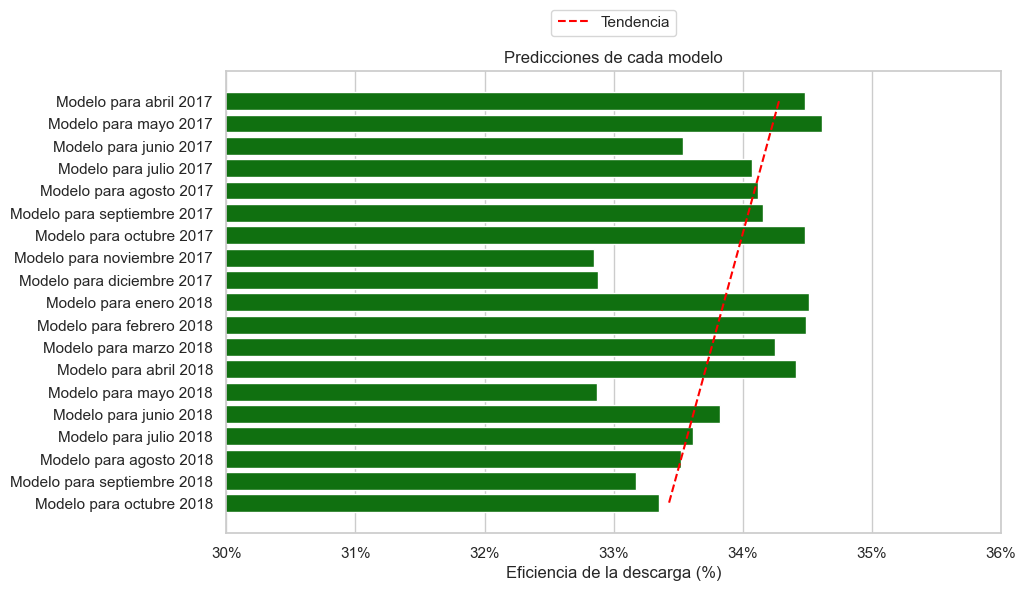

In [64]:
# El caso a predecir se calcula con la media de todas las características del dataset
datos_inputs = datos.drop(["eficiencia_descarga", "predicciones"], axis=1).dropna()
caso_a_predecir = datos_inputs.mean().values.reshape(1, -1)

# Realizar predicciones con cada modelo
predicciones = []
for modelo in modelos:
    prediccion = modelo.predict(caso_a_predecir)
    predicciones.append(prediccion.item()) 

# Generar etiquetas con el nombre del mes en que se aplica cada modelo
etiquetas_modelos = [f"Modelo para {fecha.strftime('%B %Y')}"
                     for fecha in pd.date_range(start='2017-04-01', periods=len(modelos), freq='M')]

# Se hace un gráfico de barras con Seaborn
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=predicciones, y=etiquetas_modelos, orient="h", color='green')

# Se dibuja la línea de tendencia por regresión lineal
x = np.arange(len(predicciones))
y = np.array(predicciones)
coeficientes = np.polyfit(x, y, deg=1)
tendencia = np.polyval(coeficientes, x)
plt.plot(tendencia, x, color='red', linestyle='--', label='Tendencia')

plt.xlabel("Eficiencia de la descarga (%)")
plt.ylabel("")
plt.title("Predicciones de cada modelo")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3) # Posición de la leyenda
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0)) # Formato con porcentajes para las eficiencias
plt.xlim(0.3, 0.36) # Escala
plt.show()


In [11]:
modelos

[RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                       min_samples_leaf=4, n_estimators=800),
 RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=4,
                       min_samples_split=10, n_estimators=1200),
 RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=4,
                       min_samples_split=10, n_estimators=2000),
 RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=10, n_estimators=800),
 RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=4,
                       min_samples_split=10, n_estimators=1200),
 RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=1200),
 RandomForestRegressor(max_features='sqrt', min_samples_leaf=4, n_estimators=800),
 RandomForestRegressor(max_